# Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [24]:
clients = pd.read_excel('btUTgX.xlsx', index_col=0)
complaints = pd.read_excel('EaUgXb.xlsx', index_col = 0)

# Data cleaning

In [25]:
clients.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


In [26]:
clients.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [27]:
# Check that new customers do not churn
print(clients[clients["tenure"] == 0].groupby("Churn")["TotalCharges"].count())

# Drop new clients with
clients = clients[clients["tenure"] != 0]

Churn
No    11
Name: TotalCharges, dtype: int64


In [28]:
# Adjust data types
# All the other columns type will be corrected once we convert the columns to boolean etc
clients["TotalCharges"] = pd.to_numeric(clients["TotalCharges"], errors="coerce")
clients.isna().sum().sum()

0

In [ ]:
def preprocess_addson(df: pd.DataFrame) -> pd.DataFrame:
    """
    Set to 0 all the adds-on services for clients that have not bought the main service (PhoneService and InternetService)
    Takes and returns a dataframe
    """

    new_df = df.copy()
    cols = [
        "MultipleLines",
        "OnlineSecurity",
        "OnlineBackup",
        "DeviceProtection",
        "TechSupport",
        "StreamingTV",
        "StreamingMovies"
    ]

    service_pattern = re.compile(r".*service.*", re.IGNORECASE)
    for col in cols:
        new_df[col] = new_df[col].apply(lambda x: "No" if service_pattern.match(x) else x)

    return new_df


def convert_boolean_variables(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert all categorical variables with two possible values into booleans.
    Takes and returns a dataframe
    """

    new_df = df.copy()

    for i, col in enumerate(list(df.columns)):
        if list(df.dtypes)[i] == "object":
            values = list(set(df[col]))
            if len(values) == 2:
                # Convert the text into boolean
                new_df[col] = new_df[col].apply(lambda x: 1 if x==values[0] else 0)
    
    return new_df

In [30]:
clients_addson = preprocess_addson(clients)
clients_bool = convert_boolean_variables(clients_addson)
clients_clean = clients_bool
clients_clean.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,0,0,1,1,1,1,DSL,1,0,1,1,1,1,Month-to-month,0,Electronic check,29.85,29.85,1
5575-GNVDE,1,0,1,1,34,0,1,DSL,0,1,0,1,1,1,One year,1,Mailed check,56.95,1889.50,1


### Outliers

# Data exploration

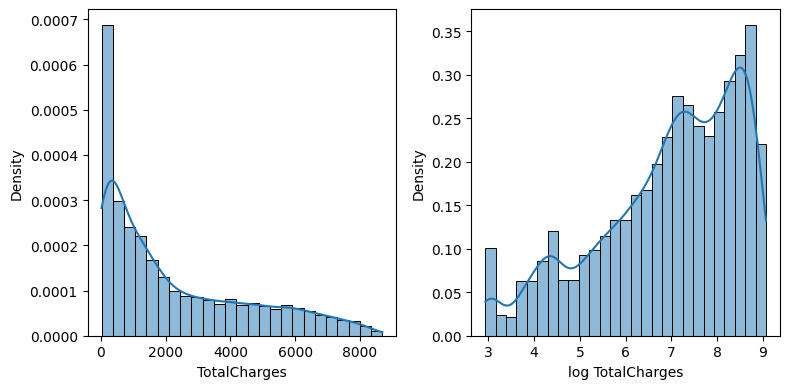

In [86]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

charges = clients_clean["TotalCharges"]
charges_ln = np.log(charges)

# plot histogram for the charges
sns.histplot(charges, kde=True, stat="density", ax=ax[0])
ax[0].set_xlim()

# plot histogram for logarithm of the charges
sns.histplot(charges_ln, kde=True, stat="density", ax=ax[1])
ax[1].set_xlabel("log TotalCharges")

plt.tight_layout()
plt.show()

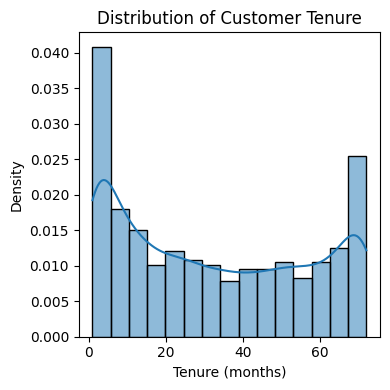

In [ ]:
# Create a figure with one subplot
plt.figure(figsize=(5   , 4))

# Plot histogram for tenure with KDE
sns.histplot(data=clients_clean, x='tenure', kde=True, stat='density')

# Customize plot
plt.title('Distribution of Customer Tenure')
plt.xlabel('Tenure (months)')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

There are no particular differences in price gaps, meaning no outliers in these categories.

In [ ]:
# Compute sorted charges
sorted_charges = sorted(clients_clean['MonthlyCharges'].dropna())

# Compute differences between consecutive values
differences = [sorted_charges[i+1] - sorted_charges[i] for i in range(len(sorted_charges)-1)]

# Compute the largest gaps
largest_gaps = sorted(enumerate(differences), key=lambda x: x[1], reverse=True)[:10]

# Compute and store the values in a DataFrame
data = {
    "Position": [pos for pos, _ in largest_gaps],
    "Gap": [gap for _, gap in largest_gaps],
    "Charge1": [sorted_charges[pos] for pos, _ in largest_gaps],
    "Charge2": [sorted_charges[pos + 1] for pos, _ in largest_gaps]
}

largest_gaps_df = pd.DataFrame(data)

# Display the DataFrame
largest_gaps_df


,Position,Gap,Charge1,Charge2
0,1599,1.55,26.90,28.45
1,1179,1.50,21.45,22.95
2,1683,1.50,31.65,33.15
3,1787,0.85,36.85,37.70
4,1602,0.45,28.60,29.05
5,2137,0.45,46.60,47.05
6,7025,0.40,117.80,118.20
7,1788,0.40,37.70,38.10
8,1684,0.30,33.15,33.45
9,1597,0.30,26.50,26.80


# Bivariate analysis

<Axes: >

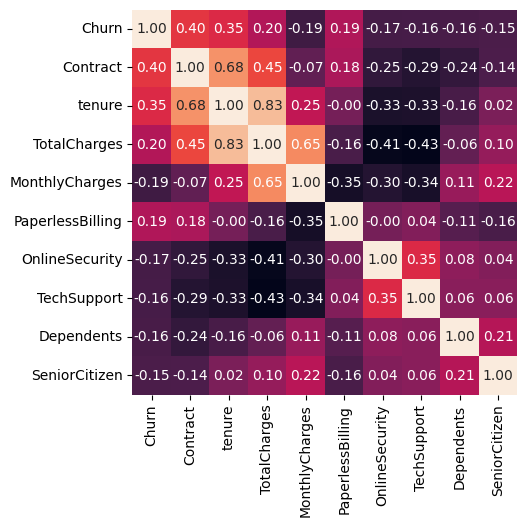

In [31]:
# remove non-numerical entries
correlation_df = clients_clean.dropna()
correlation_df["InternetService"] = LabelEncoder().fit_transform(correlation_df["InternetService"])
correlation_df["Contract"] = LabelEncoder().fit_transform(correlation_df["Contract"])
correlation_df["PaymentMethod"] = LabelEncoder().fit_transform(correlation_df["PaymentMethod"])

# compute 10 most correlated variables
cols = abs(correlation_df.corr()).nlargest(10, "Churn")["Churn"].index
coef = np.corrcoef(correlation_df[cols].values.T)

# plot heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(
    data        = coef,
    xticklabels = cols.values,
    yticklabels = cols.values,
    cbar        = False,
    square      = True,
    annot       = True,
    fmt         = ".2f",
    annot_kws   = {"size": 10},
)

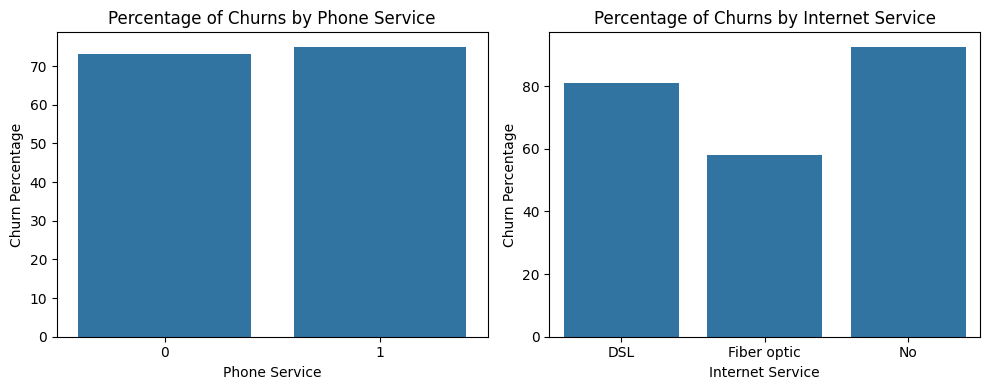

In [32]:
# Calculate the percentage of churns for each PhoneService and MultipleLines value
churn_percentage_phone = clients_clean.groupby("PhoneService")["Churn"].mean() * 100
churn_percentage_internet = clients_clean.groupby("InternetService")["Churn"].mean() * 100

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot for PhoneService
sns.barplot(ax=axes[0], x=churn_percentage_phone.index, y=churn_percentage_phone.values)
axes[0].set_title("Percentage of Churns by Phone Service")
axes[0].set_xlabel("Phone Service")
axes[0].set_ylabel("Churn Percentage")

# Plot for MultipleLines
sns.barplot(ax=axes[1], x=churn_percentage_internet.index, y=churn_percentage_internet.values)
axes[1].set_title("Percentage of Churns by Internet Service")
axes[1].set_xlabel("Internet Service")
axes[1].set_ylabel("Churn Percentage")

plt.tight_layout()
plt.show()

# Feature engineering

- internet service security: whether the customer has one of OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport
- streaming: whether the customer has one of StreamingTV, StreamingMovies
- discrepancy between expected and actual annual charges: TotalCharges - MonthlyCharges * tenure
- contract stability: whether the customer has a monthly or yearly (1 ore more) contract
- financial strain: MonthlyCharges / tenure to capture cutomer's strain \
Potentially divide over the tenure for monthly discount
- complex household: whether the customer has a partner or dependents
- payment vulnerability: whether the customer is safe (non-automatic vs automatic)

In [33]:
clients_eng = clients_clean.copy()

# Is the customer concerned about internet security?
internet_security = clients_clean[["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport"]].to_numpy()
clients_eng["InternetSecurity"] = (np.sum(internet_security, axis=1) > 0).astype(int)

# Is the customer interested in streaming?
streaming = clients_clean[["StreamingTV", "StreamingMovies"]].to_numpy()
clients_eng["Streaming"] = (np.sum(streaming, axis=1) > 0).astype(int)

# Is there a discrepancy between the expected and actual total charges?
clients_eng["ChargesDiscrepancy"] = clients_clean["TotalCharges"] - clients_clean["MonthlyCharges"] * clients_clean["tenure"]

# Is the contract stable?
clients_eng["ContractStability"] = clients_clean["Contract"].apply(lambda x: 1 if x in ["One year", "Two year"] else 0)


# Is the customer financially strained?
clients_eng["FinancialStrain"] = clients_clean["MonthlyCharges"] / clients_clean["tenure"]


# Is the household complex?
household_complexity = clients_clean[["Partner", "Dependents"]].to_numpy()
clients_eng["HouseholdComplexity"] = (np.sum(household_complexity, axis=1) > 0).astype(int)

# Is the customer payment method safe?
automatic_pattern = re.compile(r"\bautomatic\b", re.IGNORECASE)
clients_eng["PaymentSafety"] = clients_clean["PaymentMethod"].apply(lambda x: 1 if automatic_pattern.search(x) else 0)

clients_eng.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,MonthlyCharges,TotalCharges,Churn,InternetSecurity,Streaming,ChargesDiscrepancy,ContractStability,FinancialStrain,HouseholdComplexity,PaymentSafety
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,0,0,1,1,1,1,DSL,1,0,...,29.85,29.85,1,1,1,0.0,0,29.850,1,0
5575-GNVDE,1,0,1,1,34,0,1,DSL,0,1,...,56.95,1889.50,1,1,1,-46.8,1,1.675,1,0


In [34]:
# Check that no extra missing values have been introduced
clients_eng.isna().sum().sum()

0

It seems that in medium term tenure people who pay more are more reticent to churn. \
However, the total charges in the long term suggest that people paying more are more prone to churn.

In [102]:
clients_extra = clients_eng.copy()

# Correlation between TotalCharges (split into 5 categories) and Churn
bins_total = [0, 1800, 3500, 5200, 7000, float("inf")]
labels_total = ["bin_t1", "bin_t2", "bin_t3", "bin_t4", "bin_t5"]
clients_extra["bin_total"] = pd.cut(
    clients_clean["TotalCharges"],
    bins=bins_total,
    labels=labels_total,
    right=True,
    include_lowest=True
)

# Correlation between tenure (split into 5 categories) and Churn
bins_tenure = [0, 10, 20, 30, 40, float("inf")]
labels_tenure = ["bin_ten1", "bin_ten2", "bin_ten3", "bin_ten4", "bin_ten5"]
clients_extra["bin_tenur"] = pd.cut(
    clients_clean["tenure"],
    bins=bins_tenure,
    labels=labels_tenure,
    right=True,
    include_lowest=True
)

# Correlation between MonthlyCharges (split into 5 categories) and Churn
bins_month = [0, 30, 55, 75, 95, float("inf")]
labels_month = ["bin_m1", "bin_m2", "bin_m3", "bin_m4", "bin_m5"]
clients_extra["bin_month"] = pd.cut(
    clients_clean["MonthlyCharges"],
    bins=bins_month,
    labels=labels_month,
    right=True,
    include_lowest=True
)

print(clients_extra.groupby("bin_total")["Churn"].mean())
print(clients_extra.groupby("bin_tenur")["Churn"].mean())
print(clients_extra.groupby("bin_month")["Churn"].mean())

bin_total
bin_t1    0.672755
bin_t2    0.752000
bin_t3    0.835088
bin_t4    0.851648
bin_t5    0.899083
Name: Churn, dtype: float64
bin_tenur
bin_ten1    0.505870
bin_ten2    0.688326
bin_ten3    0.771953
bin_ten4    0.781395
bin_ten5    0.890098
Name: Churn, dtype: float64
bin_month
bin_m1    0.901639
bin_m2    0.715746
bin_m3    0.729814
bin_m4    0.636513
bin_m5    0.677220
Name: Churn, dtype: float64


# Model selection

Practical considerations:
- The dataset is imbalanced and to deal with this we should:
    1. Attempt to balance it
    2. Use a metric that is robust to class imbalance
- The dataset has around 7000 observation and 25 features. This implies that:
    - 60% for train = 4500
    - 20% for validation = 1200
    - 20% for test = 1200

We cannot train complex models with these numbers. I suggest we stick to:
- Logistic regression
- Bagging: Random Forest
- Boosting: XGBoost (might be too few observations)

In [35]:
# Perform one-hot encoding on the remaining categorical variables
clients_encoded = pd.get_dummies(clients_eng, drop_first=True, dtype=int)

In [36]:
# Handle class imbalance
churn_count = clients_encoded["Churn"].value_counts()
churn_count

# TODO: Use some technique to balance the classes
#  - Oversampling
#  - Undersampling
#  - SMOTE

Churn
1    5163
0    1869
Name: count, dtype: int64

In [46]:
# Split the data into train and test
X = clients_encoded.drop("Churn", axis=1)
y = clients_encoded["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [47]:
def plot_feat_imp(feat_imp, k=10):
    """"
    Plot the top k feature importances of a model"
    """

    # Get 10 highest feature importances and corresponing column names
    feat_top = np.argsort(abs(feat_imp))[-10:]
    col_names = [X_train.columns[i] for i in feat_top]

    # plot absolute feature importances
    plt.figure(figsize=(7, 5))
    plt.barh(col_names, feat_imp[feat_top])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

def round2(x):
    return round(x, 2)

### Logistic regression

              precision    recall  f1-score   support

           0       0.65      0.52      0.58       369
           1       0.84      0.90      0.87      1038

    accuracy                           0.80      1407
   macro avg       0.75      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407



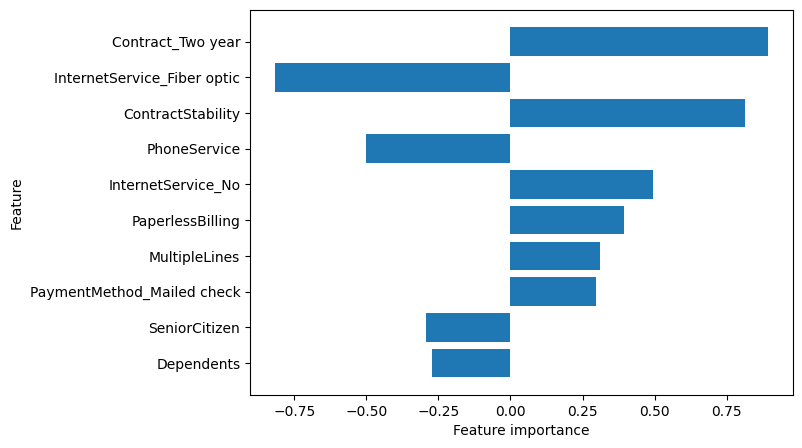

In [48]:
# Fit logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logistic = LogisticRegression(max_iter=1000)
logistic.fit(X_train, y_train)
y_pred = logistic.predict(X_test)

print(classification_report(y_test, y_pred))
plot_feat_imp(logistic.coef_[0])

### Random Forest

              precision    recall  f1-score   support

           0       0.62      0.49      0.54       369
           1       0.83      0.89      0.86      1038

    accuracy                           0.79      1407
   macro avg       0.72      0.69      0.70      1407
weighted avg       0.77      0.79      0.78      1407



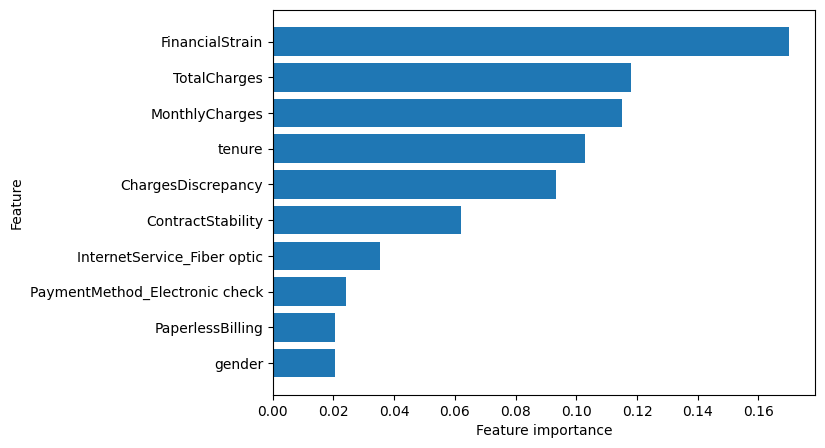

In [75]:
from sklearn.ensemble import RandomForestClassifier

# Fit random forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))
plot_feat_imp(rf.feature_importances_)

In [74]:
# Run grid search for random forest with cross validation
forest_params = {
    "max_features"      : [10, 20],
    "min_samples_split" : [5, 10, 20],
    "n_estimators"      : [100, 500],
}

forest_cv = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=forest_params,
    cv=5,
    scoring="f1" # Test others, but should work for imbalanced data
)
forest_cv.fit(X_train, y_train)

print("optimal params\t : {}\nscore (train)\t : {} \nscore (dev)\t : {}".format(
    forest_cv.best_params_, round2(forest_cv.score(X_train, y_train)), round2(forest_cv.score(X_dev, y_dev))
))

optimal params	 : {'max_features': 10, 'min_samples_split': 20, 'n_estimators': 500}
score (train)	 : 0.93 
score (dev)	 : 0.87


### Boosting

              precision    recall  f1-score   support

           0       0.62      0.49      0.54       369
           1       0.83      0.89      0.86      1038

    accuracy                           0.79      1407
   macro avg       0.72      0.69      0.70      1407
weighted avg       0.77      0.79      0.78      1407



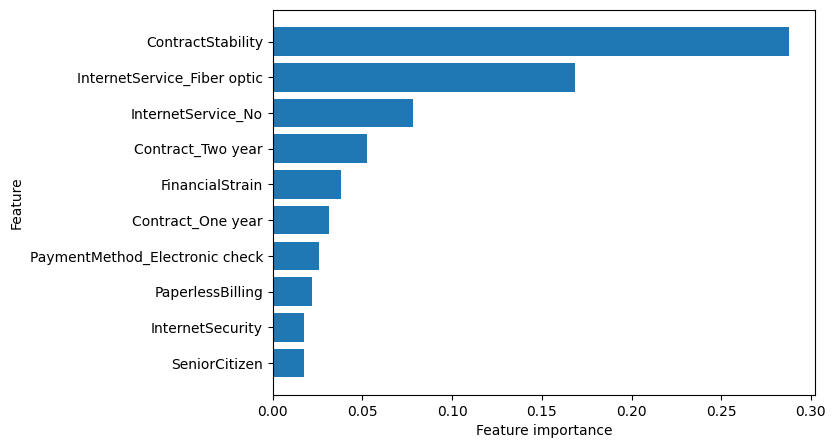

In [80]:
import xgboost

# Fit XGBoost
xgb = xgboost.XGBClassifier()
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)

print(classification_report(y_test, y_pred))
plot_feat_imp(xgb.feature_importances_)

In [83]:
# Run grid search for XGboost with cross validation
xgb_params = {
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 5, 7],
    "n_estimators": [100, 200, 500],
    "subsample": [0.8, 1.0]
}

xgb_cv = GridSearchCV(
    estimator=xgboost.XGBClassifier(objective="binary:logistic"),
    param_grid=xgb_params,
    cv=5,
    scoring="f1"
)
xgb_cv.fit(X_train, y_train)

print("optimal params\t : {}\nscore (train)\t : {} \nscore (dev)\t : {}".format(
    xgb_cv.best_params_, round2(xgb_cv.score(X_train, y_train)), round2(xgb_cv.score(X_dev, y_dev))
))

optimal params	 : {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
score (train)	 : 0.89 
score (dev)	 : 0.87


# Model evaluation